# Rust Detection

## Playground

#### Features Extraction

In [308]:
### Load data
img = Image.open('../data/samples_images/DI0623.jpeg')
img2 = Image.open('../data/samples_images/DE1064.jpeg')

In [4]:
### Load pre-trained model
vgg16 = models.vgg16(pretrained=True)
# print(vgg16)

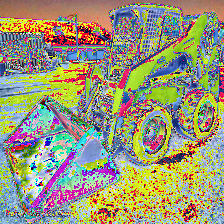

In [241]:
### Transformation (potentially augmentation)
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])])

img_t = transform(img)
transforms.functional.to_pil_image(img_t, mode=None)

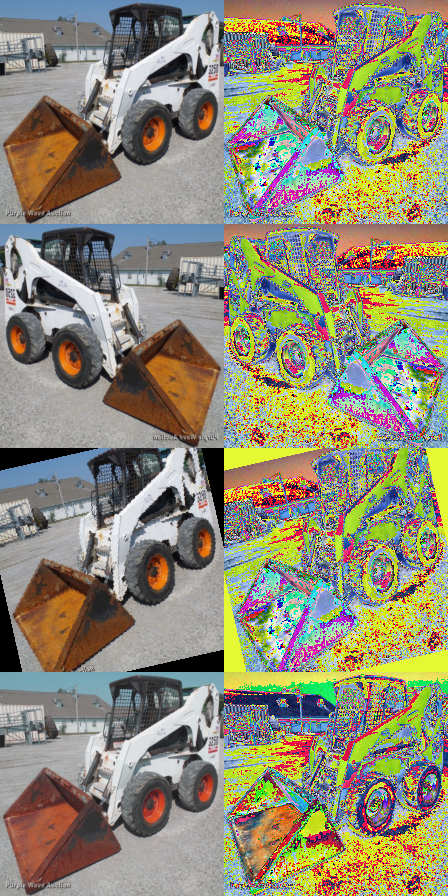

In [295]:
### Augmentation
resize = transforms.Resize((224, 224))
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
totensor = transforms.ToTensor()
augment = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomAffine(degrees=20, fillcolor=0),
    transforms.RandomHorizontalFlip(p=0.5)])

color = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05)
affine = transforms.RandomAffine(degrees=20, fillcolor=0)
hflip = transforms.RandomHorizontalFlip(p=1)

aug_plt = torch.cat([totensor(resize(img)), img_t], dim=2)
for aug in [hflip, affine, color]:
    test = totensor(aug(resize(img)))
    test_t = norm(test)
    test_plt = torch.cat([test, test_t], dim=2)
    aug_plt = torch.cat([aug_plt, test_plt], dim=1)
transforms.functional.to_pil_image(aug_plt, mode=None)

In [190]:
batch_t = torch.unsqueeze(img_t, 0)
batch_t.shape

torch.Size([1, 3, 224, 224])

In [57]:
### Freezing or fine-tuning
print("all params trainable: ", all([param.requires_grad for param in vgg16.parameters()]))

## freezing features (fine-tuning)
for param in vgg16.features.parameters():
    param.requires_grad = False

print("freezed feature layers:", not any([param.requires_grad for param in vgg16.features.parameters()]))
print("fine-tuning classifier layers:", all([param.requires_grad for param in vgg16.classifier.parameters()]))

all params trainable:  False
freezed feature layers: True
fine-tuning classifier layers: True


In [58]:
### Transfering layers
num_features =  vgg16.classifier[-1].in_features  # 4096
classifiers = list(vgg16.classifier.children())[:-1]  # drop the last layer
classifiers.extend([nn.Linear(num_features, 5)])  # Add our layer with 4 outputs
vgg16.classifier = nn.Sequential(*classifiers) # Replace the model classifier
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [75]:
### loss funciton
criterion = nn.CrossEntropyLoss()

In [80]:
### optimizer and learning rate
optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [338]:
vgg16.train(False)
vgg16.eval()
out = vgg16(batch_t)
out

tensor([[ 0.1958,  0.2428,  0.2772, -0.0682, -0.0643]],
       grad_fn=<AddmmBackward>)

In [48]:
vgg16(batch_t)

tensor([[ 0.4874,  0.7017, -0.2328,  0.2241, -0.8674]],
       grad_fn=<AddmmBackward>)

---

In [329]:
from PIL import Image
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import models, datasets, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [654]:
ROOT_DIR = "../data/images"
LABELS_FILE = "../data/labels/labeled_corrosion.csv"
LABELS_FILE = "../data/labels/mturk_rusk_11-14_truth.csv"

## Loading Data

In [655]:
class CorrosionDetection_Dataset(Dataset):
    """Corrosion Detection dataset."""

    def __init__(self, 
                 csv_file, 
                 root_dir, 
                 transform=None, 
                 normalize=None, 
                 augment=None, 
                 attachment="drop", 
                 split=[0.7, 0.1, 0.2], 
                 seed=1):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        np.random.seed(seed)
        self.root_dir = root_dir
        self.transform = transform
        self.normalize = normalize
        self.augment = augment
        # labels
        df_labels = pd.read_csv(csv_file, index_col=0).sample(frac=1)
        if attachment == "drop":
            self.df_labels = df_labels[df_labels.attached == 1]
        elif attachment == "ignore":
            self.df_labels = df_labels   # TODO
        elif attachment == "add_cat":
            self.df_labels = df_labels   # TODO
        else:
            raise ValueError("invalid attachment value")
        # splits
        assert len(split) == 3 and sum(split) == 1, "invalid split value"
        n = len(self.df_labels)
        a, b, c = tuple(np.array(split) * n)
        self.train_ids = np.arange(0, int(a))
        self.valid_ids = np.arange(int(a), int(a)+int(b))
        self.test_ids = np.arange(int(a)+int(b), n)
        
        

    def __len__(self):
        return len(self.df_labels)

    def __getitem__(self, idx):
        '''Return one data point with a PIL image and its label.'''
        img_dir = os.path.join(self.root_dir, self.df_labels.index[idx])
        # corrosion = self.df_labels.five[idx]
        corrosion = self.df_labels.three[idx]
        image = Image.open(img_dir)
        if self.transform:
            image = self.transform(image)
        sample = {'image': image, 'corrosion': corrosion}
        return sample
    
    def get_data(self, ids, aug=0):
        '''Return multiple data point in tensors.'''
        assert type(aug) == int, "invalid aug input"
        data = []
        labels = []
        if aug == 0:
            for i in ids:
                item = self[i]
                data.append(self.normalize(item["image"]))
                labels.append(item["corrosion"])
        else:
            for i in ids:
                item = self[i]
                for j in range(aug):
                    data.append(self.normalize(self.augment(item["image"])))
                    labels.append(item["corrosion"])
            # TODO
        
        return torch.stack(data, 0), torch.tensor(labels)-1
    
    def get_train(self, aug=0):
        return self.get_data(ids=self.train_ids, aug=aug)
    
    def get_valid(self):
        return self.get_data(ids=self.valid_ids, aug=0)
    
    def get_test(self):
        return self.get_data(ids=self.test_ids, aug=0)

In [656]:
### Load, Transform, Augment and Split Data

TRANSFORM = transforms.Resize((224, 224))
AUGMENT = transforms.Compose([
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomAffine(degrees=10, fillcolor=0),
    transforms.RandomHorizontalFlip(p=0.5)])
NORMALIZE = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])    
])

corrosion_dataset = CorrosionDetection_Dataset(csv_file=LABELS_FILE, 
                                               root_dir=ROOT_DIR, 
                                               transform=TRANSFORM, 
                                               normalize=NORMALIZE, 
                                               augment=AUGMENT, 
                                               split=[0.7, 0.0, 0.3], 
                                               attachment="ignore", 
                                               seed=1)

AUG_TIMES = 5
train_data, train_label = corrosion_dataset.get_train(aug=AUG_TIMES)
# valid_data, valid_label = corrosion_dataset.get_valid(aug=AUG_TIMES)
test_data, test_label = corrosion_dataset.get_test()

In [662]:
def model_eval_classification(model, test_X, test_y, criterion):
    num_batch = 10
    model.eval()
    num_data = test_X.shape[0]
    ids = np.linspace(0, num_data, num_batch+1, dtype=int)
    loss = 0
    acc = 0
    with torch.no_grad():
        for i, j in zip(ids[:-1], ids[1:]):
            y_hat = model(test_X[i:j])
            loss += criterion(y_hat, test_y[i:j])
            acc += (y_hat.max(dim=1).indices == test_y[i:j]).sum()
    return loss.div(num_batch).item(), acc.float().div(num_data).item()

In [663]:
def model_train_classfication(model, train_X, train_y, test_X, test_y, 
                              criterion, optimizer, num_epoch, batch_size, seed=1):
    torch.manual_seed(seed)
    batch_ids = np.arange(0, len(train_X) + batch_size, batch_size)
    train_n = len(train_X)
    for epoch in range(num_epoch):
        model.train()
        train_loss = 0
        train_acc = 0
        for batch_idl, batch_idr in zip(batch_ids[:-1], batch_ids[1:]):
            batch_x = train_X[batch_idl:batch_idr]
            batch_y = train_y[batch_idl:batch_idr]
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(batch_x)
            train_acc += (output.max(dim=1).indices == batch_y).sum()
        test_loss, test_acc = model_eval_classification(model, test_X, test_y, criterion)
        print("Epoch %d:" % (epoch+1))
        print("    Train Loss: {:.4f} ACC: {:.2f}".format(train_loss/train_n, 100*train_acc/train_n))
        print("    Test Loss: {:.4f} ACC: {:.2f}".format(test_loss, 100*test_acc))

In [664]:
def model_eval_regression(model, test_X, test_y, criterion):
    num_batch = 10
    model.eval()
    num_data = test_X.shape[0]
    ids = np.linspace(0, num_data, num_batch+1, dtype=int)
    loss = 0
    acc = 0
    with torch.no_grad():
        for i, j in zip(ids[:-1], ids[1:]):
            y_hat = model(test_X[i:j])
            loss += criterion(y_hat, test_y[i:j]) * int(j-i)
    return loss.div(num_data).item()

In [665]:
def model_train_regression(model, train_X, train_y, test_X, test_y, 
                           criterion, optimizer, num_epoch, batch_size, seed=1):
    torch.manual_seed(seed)
    batch_ids = np.arange(0, len(train_X) + batch_size, batch_size)
    train_n = len(train_X)
    for epoch in range(num_epoch):
        model.train()
        train_loss = 0
        train_acc = 0
        for batch_idl, batch_idr in zip(batch_ids[:-1], batch_ids[1:]):
            batch_x = train_X[batch_idl:batch_idr]
            batch_y = train_y[batch_idl:batch_idr]
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(batch_x)
            train_acc += (output.max(dim=1).indices == batch_y).sum()
        test_loss, test_acc = model_eval_regression(model, test_X, test_y, criterion)
        print("Epoch %d:" % (epoch+1))
        print("    Train Loss: {:.4f}".format(train_loss/train_n))
        print("    Test Loss: {:.4f}".format(test_loss))

In [666]:
### Load pre-trained model
model = models.vgg16(pretrained=True)

### Freezing or fine-tuning
print("All params trainable: ", all([param.requires_grad for param in model.parameters()]))

## freezing features (fine-tuning)
for param in model.features.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = False

print("Freeze feature layers:", not any([param.requires_grad for param in model.features.parameters()]))
print("Fine-tuning classifier layers:", all([param.requires_grad for param in model.classifier.parameters()]))

### Transfering layers
num_features =  model.classifier[-1].in_features  # 4096
classifiers = list(model.classifier.children())[:-1]  # drop the last layer
classifiers.extend([nn.Linear(num_features, 5)])  # Add our layer with 4 outputs
model.classifier = nn.Sequential(*classifiers) # Replace the model classifier
# print(model)

print("\nFine-tuning: ")
for param in model.parameters():
    if param.requires_grad:
        print(param.shape)

All params trainable:  True
Freeze feature layers: True
Fine-tuning classifier layers: False

Fine-tuning: 
torch.Size([5, 4096])
torch.Size([5])


In [667]:
### loss funciton
criterion = nn.CrossEntropyLoss()

### optimizer and learning rate
optimizer = optim.Adam(model.parameters())
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_train_classfication(model, train_data, train_label, test_data, test_label,
                          criterion, optimizer, num_epoch=20, batch_size=16)

Epoch 1:
    Train Loss: 1.4586 ACC: 34.00
    Test Loss: 1.5387 ACC: 37.88
Epoch 2:
    Train Loss: 1.1298 ACC: 46.00
    Test Loss: 1.3950 ACC: 36.36
Epoch 3:
    Train Loss: 1.0150 ACC: 51.00
    Test Loss: 1.5478 ACC: 37.88
Epoch 4:
    Train Loss: 0.9349 ACC: 56.00
    Test Loss: 1.6309 ACC: 37.88
Epoch 5:
    Train Loss: 0.9334 ACC: 58.00
    Test Loss: 1.6573 ACC: 37.88
Epoch 6:
    Train Loss: 0.8669 ACC: 62.00
    Test Loss: 1.6913 ACC: 36.36
Epoch 7:
    Train Loss: 0.8410 ACC: 63.00
    Test Loss: 1.8795 ACC: 36.36
Epoch 8:
    Train Loss: 0.8541 ACC: 61.00
    Test Loss: 1.7942 ACC: 39.39
Epoch 9:
    Train Loss: 0.8178 ACC: 64.00
    Test Loss: 1.7712 ACC: 36.36
Epoch 10:
    Train Loss: 0.7811 ACC: 64.00
    Test Loss: 1.8982 ACC: 37.88
Epoch 11:
    Train Loss: 0.7668 ACC: 66.00
    Test Loss: 1.8553 ACC: 37.88
Epoch 12:
    Train Loss: 0.7150 ACC: 69.00
    Test Loss: 1.9711 ACC: 36.36
Epoch 13:
    Train Loss: 0.7703 ACC: 67.00
    Test Loss: 1.9670 ACC: 37.88
Epoch 14

In [676]:
### Load pre-trained model
model = models.vgg16(pretrained=True)

### Freezing or fine-tuning
print("All params trainable: ", all([param.requires_grad for param in model.parameters()]))

## freezing features (fine-tuning)
for i, param in enumerate(model.features.parameters()):
    if i >= 26 - 2:
        param.requires_grad = True
    else:
        param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = False

print("Freeze feature layers:", not any([param.requires_grad for param in model.features.parameters()]))
print("Fine-tuning classifier layers:", all([param.requires_grad for param in model.classifier.parameters()]))

### Transfering layers
num_features =  model.classifier[-1].in_features  # 4096
classifiers = list(model.classifier.children())[:-1]  # drop the last layer
classifiers.extend([nn.Linear(num_features, 5)])  # Add our layer with 4 outputs
model.classifier = nn.Sequential(*classifiers) # Replace the model classifier
# print(model)

print("\nFine-tuning: ")
for param in model.parameters():
    if param.requires_grad:
        print(param.shape)

All params trainable:  True
Freeze feature layers: False
Fine-tuning classifier layers: False

Fine-tuning: 
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([5, 4096])
torch.Size([5])


In [677]:
### loss funciton
criterion = nn.CrossEntropyLoss()

### optimizer and learning rate
optimizer = optim.Adam(model.parameters())
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_train_classfication(model, train_data, train_label, test_data, test_label,
                          criterion, optimizer, num_epoch=10, batch_size=16, seed=1)

Epoch 1:
    Train Loss: 1.2781 ACC: 35.00
    Test Loss: 1.1323 ACC: 37.88
Epoch 2:
    Train Loss: 1.1565 ACC: 39.00
    Test Loss: 1.1055 ACC: 37.88
Epoch 3:
    Train Loss: 1.1470 ACC: 40.00
    Test Loss: 1.1445 ACC: 37.88
Epoch 4:
    Train Loss: 1.0830 ACC: 43.00
    Test Loss: 1.1157 ACC: 33.33
Epoch 5:
    Train Loss: 0.9923 ACC: 53.00
    Test Loss: 1.1606 ACC: 39.39
Epoch 6:
    Train Loss: 0.9539 ACC: 57.00
    Test Loss: 1.2888 ACC: 42.42
Epoch 7:
    Train Loss: 0.8162 ACC: 64.00
    Test Loss: 1.4835 ACC: 40.91
Epoch 8:
    Train Loss: 0.7684 ACC: 66.00
    Test Loss: 1.5126 ACC: 36.36
Epoch 9:
    Train Loss: 0.7814 ACC: 67.00
    Test Loss: 1.4774 ACC: 40.91
Epoch 10:
    Train Loss: 0.7357 ACC: 68.00
    Test Loss: 1.4537 ACC: 37.88


In [543]:
### training

NUM_EPOCH = 5
BATCH_SIZE = 16

batch_ids = np.arange(0, len(train_data) + BATCH_SIZE, BATCH_SIZE)
train_n = len(train_data)
for epoch in range(NUM_EPOCH):
    model.train()
    train_loss = 0
    train_acc = 0
    for batch_idl, batch_idr in zip(batch_ids[:-1], batch_ids[1:]):
        batch_x = train_data[batch_idl:batch_idr]
        batch_y = train_label[batch_idl:batch_idr]
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(batch_x)
        train_acc += (output.max(dim=1).indices == batch_y).sum()
    test_loss, test_acc = model_eval(model, test_data, test_label, criterion)
    print("Epoch %d:" % (epoch+1))
    print("    Train Loss: {:.4f} ACC: {:.2f}".format(train_loss/train_n, 100*train_acc/train_n))
    print("    Test Loss: {:.4f} ACC: {:.2f}".format(test_loss, 100*test_acc))

Epoch 1:
    Train Loss: 1.7820 ACC: 21.00
    Test Loss: 1.7604 ACC: 30.00
Epoch 2:
    Train Loss: 1.6715 ACC: 31.00
    Test Loss: 1.6716 ACC: 26.67
Epoch 3:
    Train Loss: 1.3922 ACC: 38.00
    Test Loss: 1.6330 ACC: 20.00
Epoch 4:
    Train Loss: 1.1583 ACC: 60.00
    Test Loss: 1.6815 ACC: 16.67
Epoch 5:
    Train Loss: 1.0259 ACC: 62.00
    Test Loss: 1.7089 ACC: 20.00


In [581]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [ ]:
classifiers = nn.Sequential(
                nn.Linear(25088))

# Random Stuffs

In [397]:
df_labels = pd.read_csv(LABEL_PATH, index_col=0).sample(frac=1)
df_labels.iloc[:5, ]

,attached,binary,five
img,,,
rbauction_10336630.jpg,1,0,1
rbauction_10311671.jpg,1,1,3
PW_DF8043.jpg,1,0,2
bigiron_CW5318.jpg,1,1,4
rbauction_10332680.jpg,1,0,2


In [365]:
t = np.array([0.7, 0.1, 0.2])
np.round(t[1:] * 110)

array([11., 22.])

In [361]:
110 - sum(t[-2:] * 110)

77.0

In [372]:
df_labels.loc[df_labels.index[:5]]

,attached,binary,five
img,,,
PW_BY9534.jpg,1,1,5
rbauction_11110906.jpg,1,0,1
rbauction_10336630.jpg,1,0,1
rbauction_10818639.jpg,1,0,1
rbauction_9951576.jpg,1,1,3


In [100]:
def load_data(IMG_PATH, LABEL_PATH, seed=1, attachment="drop"):
    ''' Return a list of shuffled PIL images.'''
    assert attachment in ["drop", "ignore", "label0"], "invalid action for attachment"
    np.random.seed(seed)
    df_label = pd.read_csv(LABEL_PATH, index_col=0).sample(frac=1)
    imgs = list(df_label.index)
    
    
    
    
    return df_label

In [316]:
df_labels = pd.read_csv(LABEL_PATH, index_col=0).sample(frac=1)
imgs = list(df_labels.index)
df_labels.index[1]

'PW_2168.jpg'

In [307]:
c = 0
for img in os.listdir(IMG_PATH):
    if img in imgs:
        c += 1
c

100

In [320]:
df_labels[df_labels.attached == 1]

,attached,binary,five
img,,,
rbauction_10832101.jpg,1,1,3
PW_2168.jpg,1,0,2
PW_DD2687.jpg,1,1,2
rbauction_10663977.jpg,1,1,4
rbauction_10867486.jpg,1,1,3
...,...,...,...
rbauction_10227578.jpg,1,1,3
rbauction_10320903.jpg,1,1,5
rbauction_11114023.jpg,1,1,5
